In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [2]:
n_samples = 100
X = pd.DataFrame(np.random.randn(n_samples, 2), columns = ['X1','X2'])
y = 3 * X['X1'] + 2 + pd.Series(np.random.randn(n_samples).squeeze(), name='y')

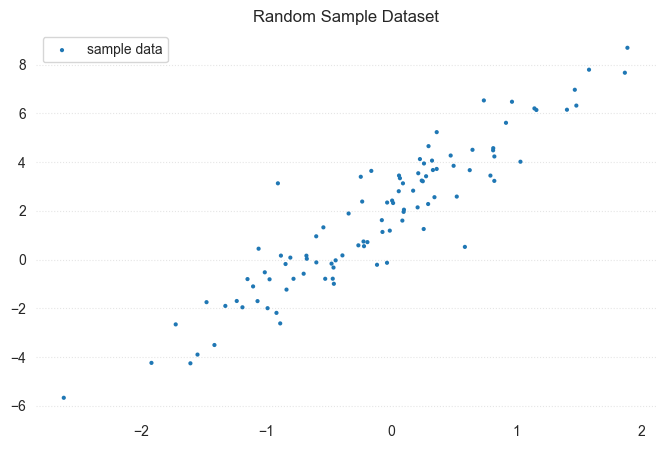

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(X['X1'], y, label = 'sample data', lw = 0.5, marker = '.', edgecolor = 'None')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Random Sample Dataset')
plt.show()

In [9]:
from FinancialDeepLearning.regression.linear_model import LinearNet
linear_net = LinearNet(X, y)

In [10]:
linear_net_fit = linear_net.fit(
    criterion = 'mse',
    optimizer = 'SGD',
    activation_function = 'silu',
    hidden_layers = [],
    learning_rate = 0.01,
    num_epochs = 10
)

100%|██████████| 10/10 [00:00<00:00, 1201.50it/s]


In [11]:
print(linear_net.summary())

                    LinearNet Results
Dep. Variable:    predicted        R-squared:     0.1058  
Model:            LinearNet        MSE:           7.6002  
Date:             Wed, 25 Sep 2024 Log Likelihood -244.825
Time:             01:28:14         AIC            497.651 
Sample:           100              BIC            508.071 
No. Observations: 100              HQIC           501.868 
-----------------------------------------------------------
          coef   std err     t     P>|t|    [0.025   0.975]
-----------------------------------------------------------
const    0.8456   0.3293   2.5682  0.0117   0.2002   1.4909
X1       0.4718   0.3237   1.4575  0.1482  -0.1627   1.1063
X2      -0.5821   0.2775  -2.0973  0.0386  -1.1261  -0.0381
----------------------------------------------------------
Jarque-Bera Test:    0.86     Durbin-Watson:         1.92 
Prob(JB):            0.65     Breusch-Pagan Test:    22.23
Skew:                0.05     Prob(H):               0.00 
Kurtosis:   

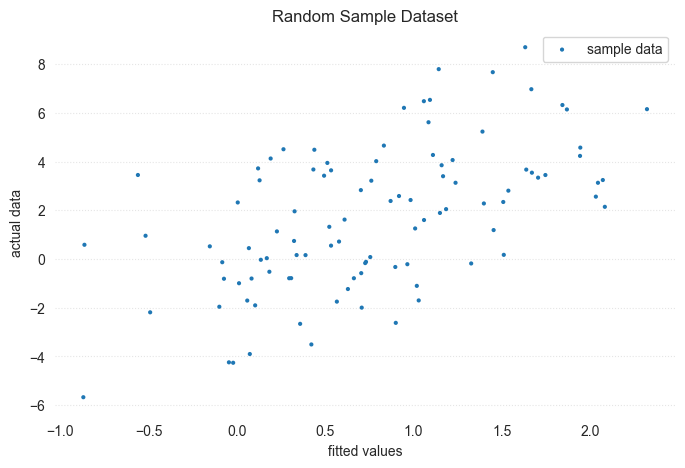

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(
    linear_net.fittedvalues(), y, 
    label = 'sample data', 
    lw = 0.5,
    marker = '.', 
    edgecolor = 'None'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.xlabel('fitted values')
plt.ylabel('actual data')
plt.title('Random Sample Dataset')
plt.show()

### Factor Models with Neural Net

In [15]:
import pandas_datareader as pdr

data = pdr.DataReader(
    'F-F_Research_Data_Factors_daily', 
    'famafrench', 
    start = '1980-01-01'
)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_15653/2413652644.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.DataReader(


In [20]:
fama = data[0].astype(float) * 0.01

In [26]:
fama['RF'] = ((fama['RF'] * 100) / 252)

In [28]:
fama.index = pd.to_datetime(fama.index)

In [33]:
import yfinance as yf

aapl = yf.download(
    'AAPL',
    start = '1999-12-31',
    end = '2024-08-01',
    progress = False
)

In [39]:
fama = fama.loc[aapl.index]

In [40]:
fama['asset-RF'] = aapl['Close'].pct_change().dropna() - fama['RF']

In [55]:
fama.dropna(inplace = True)

In [65]:
X = fama[['Mkt-RF','SMB','HML']]
y = fama['asset-RF']

In [73]:
linear_net = LinearNet(X, y)

In [74]:
linear_net_fit = linear_net.fit(
    criterion = 'mse',
    optimizer = 'ADAM',
    activation_function = 'silu',
    hidden_layers = [8, 4, 2],
    learning_rate = 0.1,
    num_epochs = 100
)

100%|██████████| 100/100 [00:00<00:00, 313.34it/s]


In [75]:
print(linear_net.summary())

                     LinearNet Results
Dep. Variable:    predicted        R-squared:     0.2843    
Model:            LinearNet        MSE:           0.0004    
Date:             Wed, 25 Sep 2024 Log Likelihood 15171.386 
Time:             01:42:10         AIC            -30332.771
Sample:           6183             BIC            -30299.124
No. Observations: 6183             HQIC           -30321.104
-------------------------------------------------------------
          coef   std err      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------
const    0.2862   0.0009   309.5661  0.0000   0.2844   0.2880
Mkt-RF   9.0393   0.0215   420.4545  0.0000   8.9971   9.0814
SMB      4.0548   0.0417    97.2738  0.0000   3.9731   4.1365
HML     -5.5971   0.0339  -165.3047  0.0000  -5.6635  -5.5307
------------------------------------------------------------
Jarque-Bera Test:    1021013.17   Durbin-Watson:        2.03
Prob(JB):            0.00         Breus

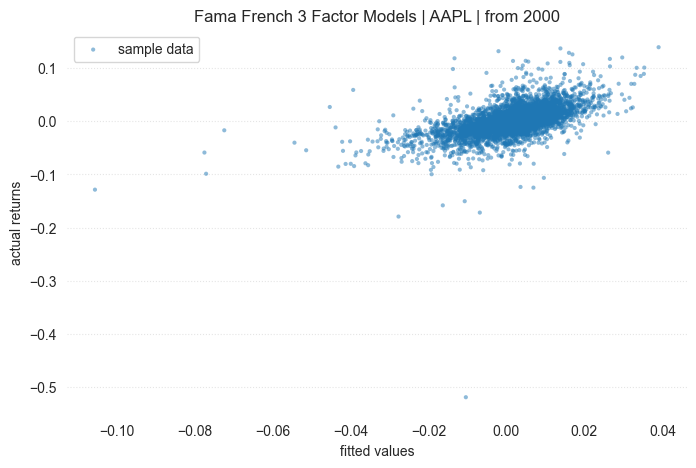

In [78]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(
    linear_net.fittedvalues(), y, 
    label = 'sample data', 
    lw = 0.5,
    marker = '.', 
    edgecolor = 'None',
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.xlabel('fitted values')
plt.ylabel('actual returns')
plt.title('Fama French 3 Factor Models | AAPL | from 2000')
plt.show()